# 0. Imports

## 0.0. Imports

In [98]:
import numpy   as np
import pandas  as pd
import seaborn as sns

from matplotlib            import pyplot as plt
from IPython.display       import HTML
from yellowbrick.cluster   import KElbowVisualizer

from plotly                import express as px
from sklearn               import cluster as c
from sklearn               import metrics as m

## 0.1. Helper Functions 

In [99]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [18, 9]
    plt.rcParams['font.size'] = 24
    
    sns.set
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Dataset

In [100]:
# load data
df_raw = pd.read_csv('/home/joaohenritm/repos/insiders_clustering/data/raw/Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# 1. Data Description

In [101]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [102]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimensions

In [103]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3.  Data Types

In [104]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [105]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [106]:
# remove NA
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format(100*(1-(df1.shape[0]/df_raw.shape[0]))))

Removed data: 24.93%


In [107]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6. Change Types

In [108]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [109]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## 1.7. Descriptive Statistics

# 2. Feature Engineering

In [110]:
df2 = df1.copy()

## 2.1. Feature Creation

In [111]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'description',
                   'quantity', 'invoice_date', 'unit_price',
                   'country'], axis=1).drop_duplicates(ignore_index=True)

In [112]:
# Gross Revenue
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last Day Purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

# 3. Data Filtering

In [113]:
df3 = df_ref.copy()

# 4. Exploratory Data Analysis

In [114]:
df4 = df3.copy()

# 5. Data Preparation

In [115]:
df5 = df4.copy()

# 6. Feature Selection

In [116]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tuning

In [117]:
df7 = df6.drop(columns=['customer_id'])

In [118]:
clusters = [2, 3, 4, 5, 6]

## 7.1. Within-Cluster Sum of Square (WSS)

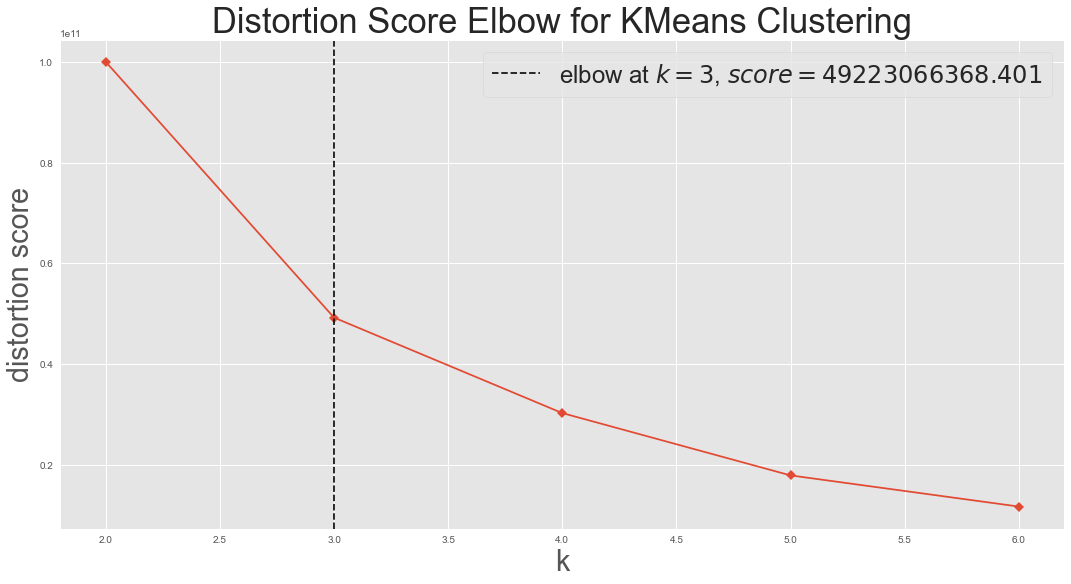

In [119]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(df7)
kmeans.show();

## 7.2. Silhouette Score

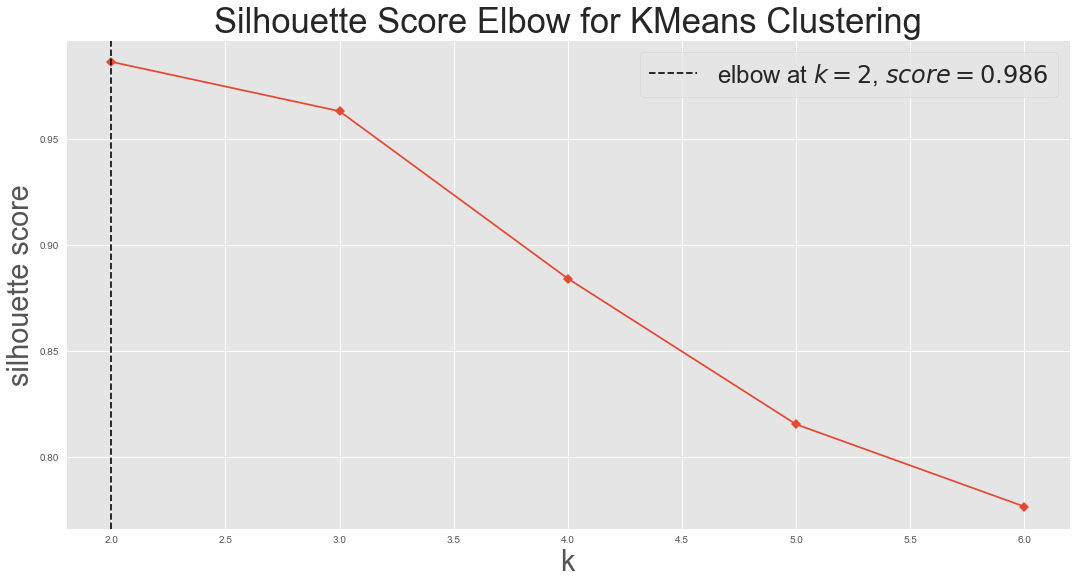

In [120]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(df7);
kmeans.show();

# 8. Model Training

In [121]:
df8 = df6.copy()

## 8.1. K-Means

In [122]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(df8)

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [123]:
## WSS ( Within-Cluster Sum of Square)
print('WSS Value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('Silhouette Score: {}'.format(m.silhouette_score(df8, labels, metric='euclidean')))

WSS Value: 65797206714.12212
Silhouette Score: 0.9165777734124003


# 9. Cluster Analysis

In [124]:
df9 = df8.copy()
df9['cluster'] = labels

## 9.1. Visualization Inspection

In [125]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

## 9.2. Cluster Profile

In [126]:
# Number of Customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Average Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Average Recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Average Invoice Number
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')


df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,4335,99.153705,1372.577826,92.257901,4.614533
1,1,6,0.137237,182181.981667,7.166667,89.000000
2,2,31,0.709058,40543.517742,13.290323,53.290323


### Cluster 01: Insiders Candidate
    - Number of Customers: 6 (0.14%)
    - Avg Recency: 7 days.
    - Avg Purchases: 89 purchases.
    - Avg Revenue: $182,182.98 dollars.

### Cluster 03:
    - Number of Customers: 14 (0.13%)
    - Avg Recency: 13 days.
    - Avg Purchases: 53 purchases.
    - Avg Revenue: $40,543.51 dollars.
    
### Cluster 03: 
    - Number of Customers: 4335 (99,15%)
    - Avg Recency: 92 days.
    - Avg Purchases: 4 purchases.
    - Avg Revenue: $1,372.57 dollars.

# 10. Deploy To Production